In [22]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from simulation_configs import generateConfigurations
from simulation_modules import DisturbanceModule, ProcessModule
import inspect
import pandas as pd
import time as real_time

In [23]:
# Repeatable results
np.random.seed(100)

In [24]:
# Generate configurations
t, d, u, p, x, f, y, r, m, econ = generateConfigurations()

In [25]:
# Inputs
u

{'x0v': 0.5,
 'xFv': 0.5,
 'xWv': 0.5,
 'PI': {'K': 0.1, 'tauI': 10},
 'intError': 0,
 'control': True,
 'dt': 1}

In [26]:
# Process parameters
p

{'A': 4, 'cv': 0.025, 'kv': 0.02, 'tauv': 60, 'dt': 1}

In [27]:
# States and intermediate variables
x

{'V': 0.004,
 'CV': 0,
 'xWv': 0,
 'C': 0.0,
 'L': 0.001,
 'F0': 0.0025,
 'FW': 0.0,
 'F': 0.00031622776601683794}

In [28]:
# Process module
print(inspect.getsource(ProcessModule))

def ProcessModule(p, u, d_now, x, f):
    # Intermediate variables
    x['C'] = x['CV']/x['V']
    x['L'] = x['V']/p['A']
    x['F0'] = u['x0v']*d_now['F0']
    x['FW'] = x['xWv']*p['cv']
    x['F'] = u['xFv']*p['kv']*np.sqrt(x['L'])
    # ODEs
    dVdt = x['F0'] + x['FW'] - x['F']
    dCVdt = d_now['C0']*x['F0'] - x['C']*x['F']
    dxWvdt = (1/p['tauv'])*(u['xWv'] - x['xWv'])
    # Check for fault: fail open water valve,
    if f['valveFW']['state']=='stuck' and u['control']:
        dxWvdt = 10 # fail open
    # Edge cases 
    if x['xWv']==0 and dxWvdt<0:
        dxWvdt = 0
    elif x['xWv']==1 and dxWvdt>0:
        dxWvdt = 0
    # Integration
    x['V'] = x['V'] + dVdt*p['dt']
    x['CV'] = x['CV'] + dCVdt*p['dt']
    x['xWv'] = x['xWv'] + dxWvdt*p['dt']
    # Edge cases
    x['V'] = max(0, x['V'])
    x['CV'] = max(0, x['CV'])
    x['xWv'] = max(0, min(x['xWv'],1))
    return x



In [29]:
# Generate disturbances
d_range = DisturbanceModule(d,t)

In [30]:
# Simulation
# Start timer for simulation duration
start_time = real_time.time()
# List of variables to save
results_list = ['Time (s)', 'V', 'xWv', 'C', 'L', 'F0', 'FW', 'F', 'C0']
# Preallocate numpy array to store results
results = np.full((t['N'], len(results_list)),np.nan)
# Indicate whether input changes
input_change = True
input_change_time_index = 2000
# Start simulation
print('Simulation progress:')
while t['tvector'][t['i']] < t['tmax']:
    # Current disturbance
    d_now = {col: d_range[col][t['i']] for col in ['F0', 'C0']}
    # Current input
    if input_change and t['i']>=input_change_time_index:
        u['xWv'] = 0.6
    # Process module
    x = ProcessModule(p, u, d_now, x, f)
    # Update results
    results[t['i'], :] = [t['tvector'][t['i']], 
                          x['V'], 
                          x['xWv'], 
                          x['C'], 
                          x['L'], 
                          x['F0'], 
                          x['FW'], 
                          x['F'], 
                          d_now['C0']]
    # Display progress in percent time
    if t['i'] % 100000 == 0:
        print(f'{t["tvector"][t["i"]]/t["tmax"]*100:.2f}%')
    # Update time index
    t['i'] += 1

# End timer for simulation duration
end_time = real_time.time()
# Print simulation duration
print(f'Done! Simulation duration: {end_time-start_time:.1f} seconds.')

Simulation progress:
0.00%
7.23%
14.47%
21.70%
28.94%
36.17%
43.40%
50.64%
57.87%
65.10%
72.34%
79.57%
86.81%
94.04%
Done! Simulation duration: 5.6 seconds.


In [31]:
# Convert results (numpy array) to DataFrame
df = pd.DataFrame(results, columns=results_list)
df.set_index('Time (s)', inplace=True)

array([<Axes: xlabel='Time (s)'>, <Axes: xlabel='Time (s)'>,
       <Axes: xlabel='Time (s)'>, <Axes: xlabel='Time (s)'>,
       <Axes: xlabel='Time (s)'>], dtype=object)

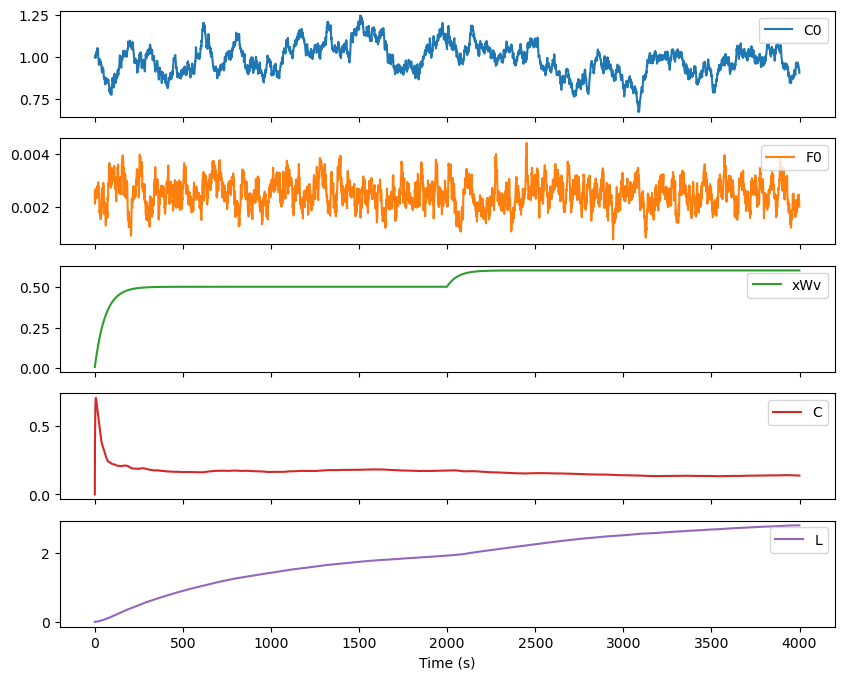

In [32]:
# Plot
plot_list = ['C0','F0','xWv','C','L']
df[plot_list].iloc[0:4000].plot(subplots=True, figsize=(10,8))